# Benchmark Testing of Query Times between AirNow API and S3 Bucket

In [8]:
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
import boto3
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
N = range(1,100,1)
TIMER = []
num_samples = []

for n in N:
    start = time.time()
    API_KEY = os.getenv("API_KEY")
    API_SECRET = os.getenv("API_SECRET")
    s3 = boto3.client('s3',aws_access_key_id = API_KEY,aws_secret_access_key= API_SECRET)
    bucket='airnow-s3'
    df = pd.DataFrame()
    prefix = '2024-03-2'

    result = s3.list_objects(Bucket = bucket,Prefix=prefix)
    
    for o in result.get('Contents')[0:n]:

        data = s3.get_object(Bucket=bucket, Key=o.get('Key'))
        contents = data['Body'].read()
        Dict = contents.decode("utf-8")
        df = pd.concat([df,pd.DataFrame(json.loads(Dict))],ignore_index=True)
    num_samples.append(len(df))
    end = time.time()
    TIMER.append(end - start)
    print('\r', n, end='')

 99

In [3]:
df_S3 =pd.DataFrame({'Samples':num_samples,'Timer':TIMER})

In [4]:
endtime = datetime.utcnow()

load_dotenv()
options = {}
options["url"] = "https://www.airnowapi.org/aq/data/"
options["parameters"] = "OZONE,PM25,PM10,CO,NO2,SO2"
options["bbox"] = "-125.0, -66.93457, 24.396308, 49.384358"
options["data_type"] = "B"
options["format"] = "application/json"
options["ext"] = "json"
options["API_KEY"] = os.getenv("API_AIRNOW")
options['includerawconcentrations'] = "0"

options["end_date"] = endtime.strftime("%Y-%m-%dT%H")
options['monitorType'] = "2"
options['verbose'] = "0"
# API request URL 

session = requests.Session()
retry = Retry(total=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)


In [5]:
TIMER = []
num_samples = []
N = range(1,6,1)
for c in range(0,20):
    for n in N:
        starttime = endtime - timedelta(hours = n)
        options["start_date"] = starttime.strftime("%Y-%m-%dT%H")
        REQUEST_URL = options["url"] \
                  + "?startDate=" + options["start_date"] \
                  + "&endDate=" + options["end_date"] \
                  + "&parameters=" + options["parameters"] \
                  + "&BBOX=" + options["bbox"] \
                  + "&dataType=" + options["data_type"] \
                  + "&format=" + options["format"] \
                  + "&verbose=" + options['verbose'] \
                + "&monitorType=" + options['monitorType'] \
                  + "&includerawconcentrations=" + options["includerawconcentrations"]\
                  + "&API_KEY=" + options["API_KEY"]
        start = time.time()
        r = session.get(REQUEST_URL)
        data = json.loads(r.text)
        df = pd.DataFrame(data)

        df_parse = pd.DataFrame()

        for i,parameter in enumerate(df['Parameter'].unique()):
            df_param = df.loc[df['Parameter'] == parameter]
            df_param = df_param.rename({'Unit':f'Unit_{parameter}','Value':f'Value_{parameter}','AQI':f'AQI_{parameter}','Category':f'Category_{parameter}'},axis=1)
            df_param = df_param.drop(labels = 'Parameter',axis=1)
            if i == 0:
                df_parse = df_param
            else:
                df_parse = df_param.merge(df_parse, on=['Latitude','Longitude','UTC'],how='outer')
        end = time.time()
        TIMER.append(end-start)
        num_samples.append(len(df_parse))
    print('\r', c, end='')


 19

In [6]:
df_API =pd.DataFrame({'Samples':num_samples,'Timer':TIMER})
counts = df_API['Samples'].value_counts(dropna=False) 
valids = counts[counts>5].index

df_API = df_API[df_API['Samples'].isin(valids)]

C:\Users\alexa\AppData\Local\Temp\ipykernel_30308\2466361118.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


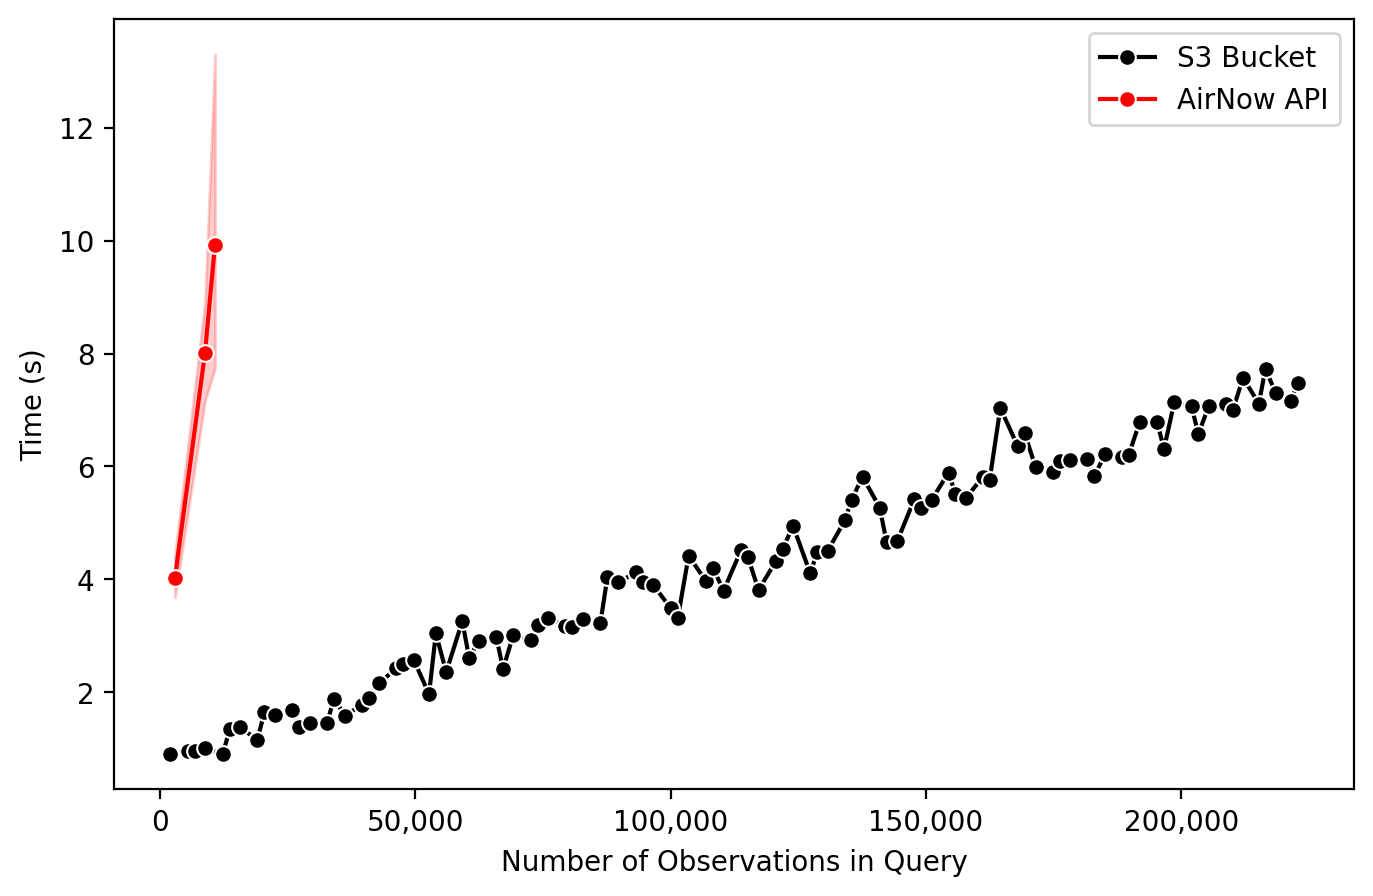

In [9]:
plt.figure(figsize=(8,5),dpi=200)
ax = sns.lineplot(data=df_S3,x='Samples',y='Timer',label='S3 Bucket',color='black',marker="o")
sns.lineplot(data=df_API,x='Samples',y='Timer',label='AirNow API',color='red',marker="o",errorbar='ci')
plt.ylabel('Time (s)')
plt.xlabel('Number of Observations in Query')
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])

plt.savefig('benchmark_1.png', dpi=300)

plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_30308\1585743584.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])


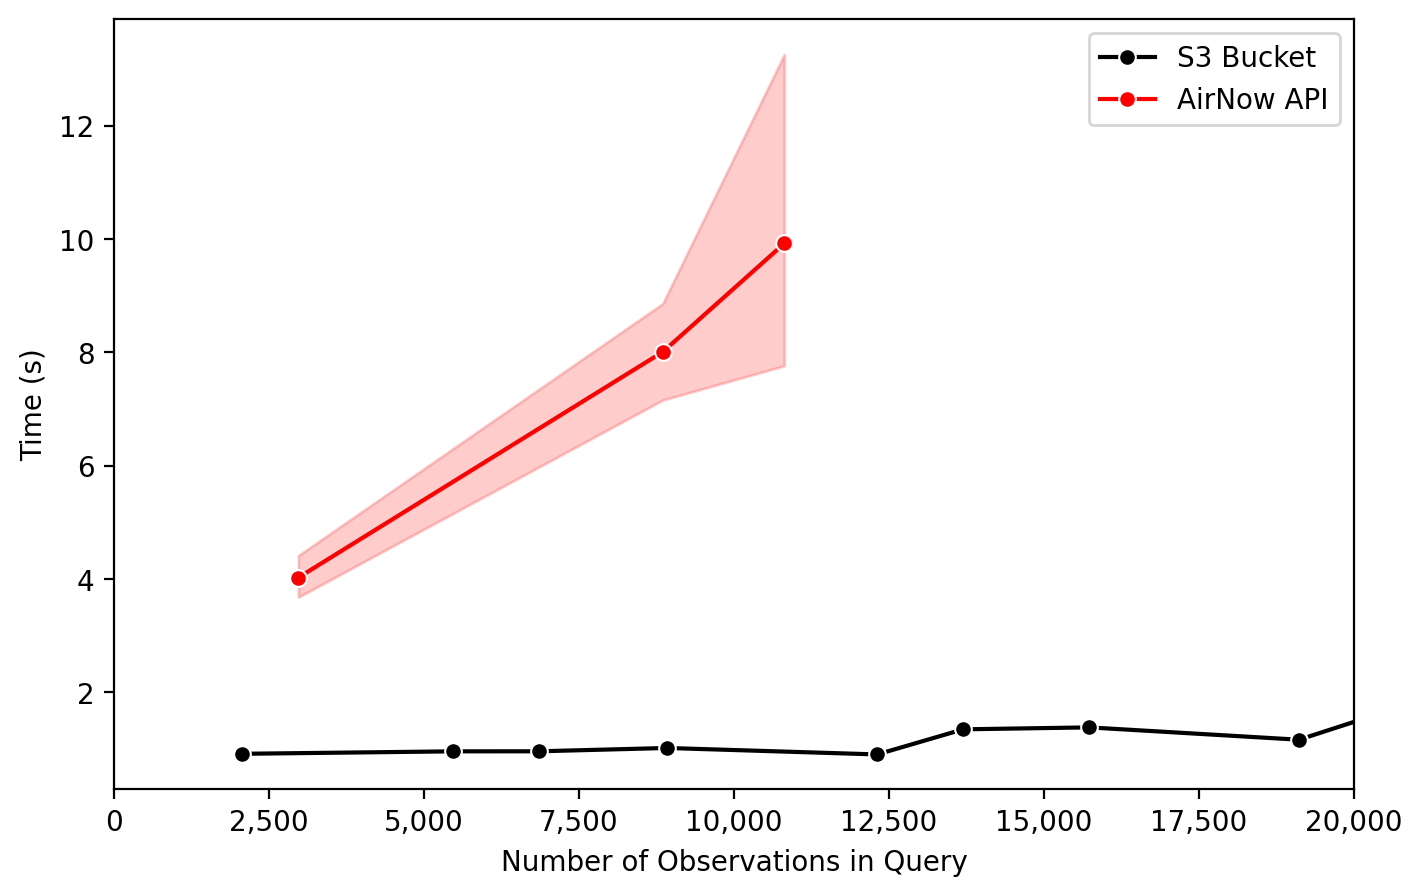

In [10]:
plt.figure(figsize=(8,5),dpi=200)
ax = sns.lineplot(data=df_S3,x='Samples',y='Timer',label='S3 Bucket',color='black',marker="o")
sns.lineplot(data=df_API,x='Samples',y='Timer',label='AirNow API',color='red',marker="o",errorbar='ci')
plt.ylabel('Time (s)')
plt.xlabel('Number of Observations in Query')
plt.xlim([0,20000])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
plt.savefig('benchmark_2.png', dpi=300)
plt.show()